# Reset and Readout of Qubit

### Import

In [1]:
#!pip install c3-toolset
#!pip install matplotlib
#!pip install plotly

In [1]:
import os
from re import I
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils
from c3.optimizers.optimalcontrol import OptimalControl

import plotly.graph_objects as go
from plotting import *
from utilities_functions import *

import scipy as sp

### Define Qubit and resonator

Qubit

In [16]:
qubit_levels = 2
qubit_frequency = 4e9
qubit_anharm = -210e6
qubit_t1 = 27e-6
qubit_t2star = 39e-6
qubit_temp = 50e-3

qubit = chip.Qubit(
    name="Q",
    desc="Qubit",
    freq=Qty(value=qubit_frequency,min_val=1e9 ,max_val=8e9 ,unit='Hz 2pi'),
    anhar=Qty(value=qubit_anharm,min_val=-380e6 ,max_val=-120e6 ,unit='Hz 2pi'),
    hilbert_dim=qubit_levels,
    t1=Qty(value=qubit_t1,min_val=1e-6,max_val=90e-6,unit='s'),
    t2star=Qty(value=qubit_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    temp=Qty(value=qubit_temp,min_val=0.0,max_val=0.12,unit='K')
)

Resonator

In [17]:
resonator_levels = 2
resonator_frequency = 5e9
resonator_t1 = 27e-6
resonator_t2star = 39e-6
resonator_temp = 50e-3

parameters_resonator = {
    "freq": Qty(value=resonator_frequency,min_val=0e9 ,max_val=8e9 ,unit='Hz 2pi'),
    "t1": Qty(value=resonator_t1,min_val=1e-6,max_val=90e-6,unit='s'),
    "t2star": Qty(value=resonator_t2star,min_val=10e-6,max_val=90e-3,unit='s'),
    "temp": Qty(value=resonator_temp,min_val=0.0,max_val=0.12,unit='K')
}

resonator = chip.Resonator(
    name="R",
    desc="Resonator",
    hilbert_dim=resonator_levels,
    params=parameters_resonator
)

Coupling

In [18]:
coupling_strength = 20e6
qr_coupling = chip.Coupling(
    name="Q-R",
    desc="coupling",
    comment="Coupling qubit and resonator",
    connected=["Q", "R"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.jaynes_cummings
)

Drives

In [19]:
drive_qubit = chip.Drive(
    name="dQ",
    desc="Drive 1",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive
)
drive_resonator = chip.Drive(
    name="dR",
    desc="Drive 2",
    comment="Drive line on resonator",
    connected=["R"],
    hamiltonian_func=hamiltonians.x_drive
)

drives = [drive_qubit, drive_resonator]

Model

In [20]:
model = Mdl(
    [qubit, resonator], # Individual, self-contained components
    [drive_qubit, drive_resonator, qr_coupling]  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(False)

sim_res = 100e9
awg_res = 2e9
v2hz = 1e9

generator = createGenerator(drives) 
generator.devices["AWG"].enable_drag_2()

In [21]:
model.get_qubit_freqs()

[4000133327.4079347, 999866672.5920658]

### Qubit X gate

In [208]:
t_X_gate = 15e-9
sideband = 50e6
gauss_params = {
    "amp": Qty(value=0.5,min_val=0.2,max_val=0.6,unit="V"),
    "t_final": Qty(value=t_X_gate,min_val=0.5 * t_X_gate,max_val=1.5 * t_X_gate,unit="s"),
    "sigma": Qty(value=t_X_gate / 4,min_val=t_X_gate / 8,max_val=t_X_gate / 2,unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit="")
}

gauss_pulse = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single qubit gates",
    params=gauss_params,
    shape=envelopes.gaussian_nonorm
)

nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_X_gate,
            min_val=0.5 * t_X_gate,
            max_val=1.5 * t_X_gate,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

## Create carriers
qubit_freqs = model.get_qubit_freqs()
carriers = createCarriers(qubit_freqs, sideband)

qubit_pulse = copy.deepcopy(gauss_pulse)
resonator_pulse = copy.deepcopy(nodrive_pulse)
X_gate = gates.Instruction(
    name="x", targets=[0], t_start=0.0, t_end=t_X_gate, channels=["dQ", "dR"]
)
X_gate.add_component(qubit_pulse, "dQ")
X_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
X_gate.add_component(resonator_pulse, "dR")
X_gate.add_component(copy.deepcopy(carriers[1]), "dR")

single_q_gates = [X_gate]

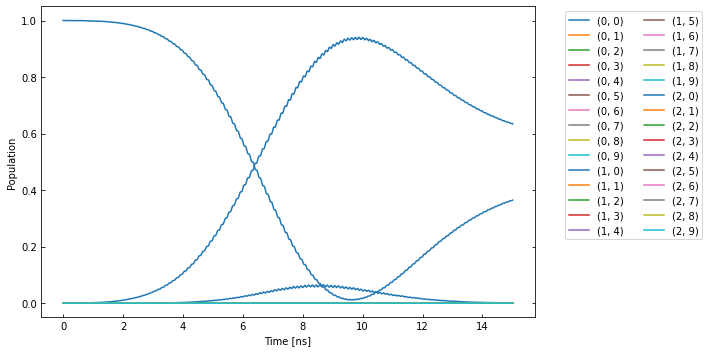

In [209]:
parameter_map = PMap(instructions=single_q_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['x[0]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['x[0]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

Optimize the X gate

In [196]:
parameter_map.set_opt_map([
    [("x[0]", "dQ", "gauss", "amp")],
    [("x[0]", "dQ", "gauss", "freq_offset")],
    [("x[0]", "dQ", "gauss", "xy_angle")],
    [("x[0]", "dQ", "gauss", "delta")],
    [("x[0]", "dR", "carrier", "framechange")]
])

parameter_map.print_parameters()

opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.average_infid_set,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun": 150},
    run_name="better_x"
)
exp.set_opt_gates(["x[0]"])
opt.set_exp(exp)

opt.optimize_controls()
opt.current_best_goal

plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=Fasle)


x[0]-dQ-gauss-amp                     : 500.000 mV 
x[0]-dQ-gauss-freq_offset             : -53.000 MHz 2pi 
x[0]-dQ-gauss-xy_angle                : -444.089 arad 
x[0]-dQ-gauss-delta                   : -1.000  
x[0]-dR-carrier-framechange           : 0.000 rad 

C3:STATUS:Saving as: c:\Users\Ashutosh\Dropbox\FZJ To read\Thorge\Qubit_readout\Ashutosh_codes\output\better_x\2021_12_09_T_13_42_57\open_loop.log


c:\files_ashutosh\qubit_reset\c3\c3\utils\utils.py:64: UserWarning:

OSError encountered while creating symlink



FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Ashutosh\\Dropbox\\FZJ To read\\Thorge\\Qubit_readout\\Ashutosh_codes\\output\\better_x\\2021_12_09_T_13_42_57\\best_point_open_loop.log'

### Readout of Resonator

In [22]:
def calculateState(
    exp: Experiment,
    psi_init: tf.Tensor,
    sequence: List[str],
    FR_op
):

    """
    Calculates the state of system with time.

    Parameters
    ----------
    exp: Experiment,
        The experiment containing the model and propagators
    psi_init: tf.Tensor,
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state

    Returns
    -------
    psi_list: List[tf.Tensor]
        List of states
    """

    dUs = exp.partial_propagators
    model = exp.pmap.model

    res_freq = tf.cast(resonator_frequency, tf.complex128)
    aR = tf.convert_to_tensor(model.ann_opers[1], dtype=tf.complex128)
    aR_dag = tf.transpose(aR, conjugate=True)
    NR = tf.matmul(aR_dag,aR)

    aQ = tf.convert_to_tensor(model.ann_opers[0], dtype=tf.complex128)
    aQ_dag = tf.transpose(aQ, conjugate=True)
    NQ = tf.matmul(aQ_dag,aQ)

    psi_t = psi_init.numpy()
    psi_list = []#[psi_t]
    
    ts = exp.ts
    ts = tf.cast(ts, tf.complex128)
    
    for gate in sequence:
        for i, du in enumerate(dUs[gate]):
            psi_t = np.matmul(du, psi_t)
            #psi_t = tf.matmul(tf.linalg.expm(1j*(FR_op)*ts[i]), psi_t)
            psi_list.append(psi_t)
    
    return psi_list


def plotNumberOperator(
    exp: Experiment, 
    init_state: tf.Tensor,
    sequence: List[str], 
    annihilation_operator: tf.Tensor,
    FR_op
):
    model = exp.pmap.model
    a_op = tf.convert_to_tensor(annihilation_operator, dtype=tf.complex128)
    a_op_dag = tf.transpose(a_op, conjugate=True)
    N_op = tf.matmul(a_op_dag,a_op)
    psi_list = calculateState(exp, init_state, sequence, FR_op)
    rho_list = np.array([tf_utils.tf_state_to_dm(i) for i in psi_list])
    expect_val = np.array([tf_utils.tf_measure_operator(N_op, i) for i in rho_list])

    dt = exp.ts[1] - exp.ts[0]
    ts = exp.ts

    fig = go.Figure()
    fig.add_trace(go.Scatter(x = ts, y = np.real(expect_val), mode = "lines", name=r'$\langle a^\dag a \rangle$'))
    fig.show()
    
    return np.real(expect_val)


def plotIQ(
        exp: Experiment, 
        sequence: List[str], 
        annihilation_operator: tf.Tensor,
        FR_op
):
    
    """
    Calculate and plot the I-Q values for resonator 

    Parameters
    ----------
    exp: Experiment,
 
    sequence: List[str], 

    annihilation_operator: tf.Tensor


    Returns
    -------
        
    """
    model = exp.pmap.model
    annihilation_operator = tf.convert_to_tensor(annihilation_operator, dtype=tf.complex128)
    
    state_index = exp.pmap.model.get_state_index((0,0))
    psi_init_0 = [[0] * model.tot_dim]
    psi_init_0[0][state_index] = 1
    init_state_0 = tf.transpose(tf.constant(psi_init_0, tf.complex128))
    
    psi_list_0 = calculateState(exp, init_state_0, sequence,FR_op)
    rho_list_0 = np.array([tf_utils.tf_state_to_dm(i) for i in psi_list_0])
    expect_val_0 = np.array([tf_utils.tf_measure_operator(annihilation_operator, i) for i in rho_list_0])
    Q0 = np.real(expect_val_0)
    I0 = np.imag(expect_val_0)
    

    state_index = exp.pmap.model.get_state_index((1,0))
    psi_init_1 = [[0] * model.tot_dim]
    psi_init_1[0][state_index] = 1
    init_state_1 = tf.transpose(tf.constant(psi_init_1, tf.complex128))
    
    psi_list_1 = calculateState(exp, init_state_1, sequence, FR_op)
    rho_list_1 = np.array([tf_utils.tf_state_to_dm(i) for i in psi_list_1])
    expect_val_1 = np.array([tf_utils.tf_measure_operator(annihilation_operator, i) for i in rho_list_1])
    Q1 = np.real(expect_val_1)
    I1 = np.imag(expect_val_1)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x = Q0, y = I0, mode = "lines", name="Ground state"))
    fig.add_trace(go.Scatter(x = Q1, y = I1, mode = "lines", name ="Excited state"))
    fig.show()


Define readout pulse for the resonator

In [27]:
t_readout = 100e-9
sideband = 50e6
readout_params = {
    "amp": Qty(value=2*np.pi*0.01,min_val=0.0,max_val=100.0,unit="V"),
    "t_final": Qty(value=t_readout,min_val=0.5 * t_readout,max_val=1.5 * t_readout,unit="s"),
    "sigma": Qty(value=t_readout / 4,min_val=t_readout / 8,max_val=t_readout / 2,unit="s"),
    "xy_angle": Qty(value=0.0,min_val=-0.5 * np.pi,max_val=2.5 * np.pi,unit="rad"),
    "freq_offset": Qty(value=-sideband - 3e6,min_val=-56 * 1e6,max_val=-52 * 1e6,unit="Hz 2pi"),
    "delta": Qty(value=-1,min_val=-5,max_val=3,unit="")
}

readout_pulse = pulse.Envelope(
    name="readout",
    desc="Gaussian pulse for readout",
    params=readout_params,
    shape=envelopes.gaussian_nonorm
)

nodrive_pulse = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_readout,
            min_val=0.5 * t_readout,
            max_val=1.5 * t_readout,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

qubit_freqs = model.get_qubit_freqs()
carriers = createCarriers(qubit_freqs, sideband)

qubit_pulse = copy.deepcopy(nodrive_pulse)
resonator_pulse = copy.deepcopy(readout_pulse)
Readout_gate = gates.Instruction(
    name="Readout", targets=[1], t_start=0.0, t_end=t_readout, channels=["dQ", "dR"]
)
Readout_gate.add_component(qubit_pulse, "dQ")
Readout_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
Readout_gate.add_component(resonator_pulse, "dR")
Readout_gate.add_component(copy.deepcopy(carriers[1]), "dR")

readout_gates = [Readout_gate]


c:\files_ashutosh\qubit_reset\c3\c3\signal\gates.py:81: UserWarning:

No ideal gate found for gate: Readout



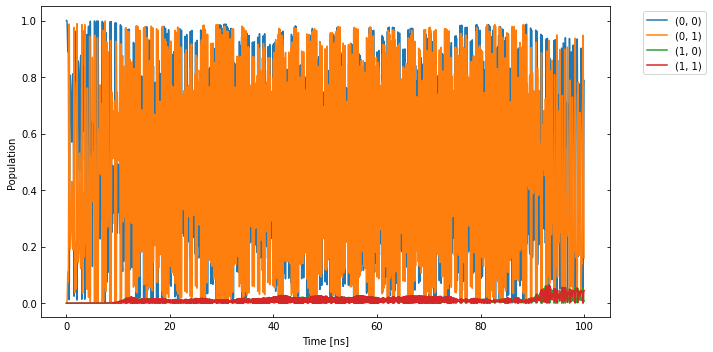

In [28]:
parameter_map = PMap(instructions=readout_gates, model=model, generator=generator)
exp = Exp(pmap=parameter_map)

model.use_FR = False

exp.set_opt_gates(['Readout[1]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['Readout[1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)


In [29]:
aR = tf.cast(model.ann_opers[1], dtype=tf.complex128)
aR_dag = tf.transpose(aR, conjugate=True)
NR = tf.matmul(aR_dag,aR)

aQ = tf.cast(model.ann_opers[0], dtype=tf.complex128)
aQ_dag = tf.transpose(aQ, conjugate=True)
NQ = tf.matmul(aQ_dag,aQ)

qubit_freqs = model.get_qubit_freqs()

FR_op = qubit_freqs[1]*NR + qubit_freqs[0]*NR 

FR_op = tf.cast(FR_op, tf.complex128)
expectval = plotNumberOperator(exp, init_state, sequence, model.ann_opers[0], FR_op)
ts = exp.ts.numpy()
plotSignalSpectrum(ts, expectval, usePlotly=True)

<Figure size 432x288 with 0 Axes>

In [41]:
plotIQ(exp, sequence, model.ann_opers[1], FR_op)

### Qubit Resonator SWAP

Define SWAP gate for qubit and resonator by using Rabi oscillations

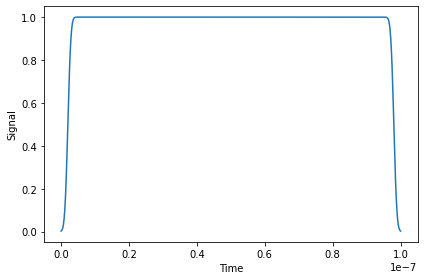

1.0007996802557464


In [7]:
t_swap_gate = 100e-9
sideband = 50e6

swap_params = {
    "amp": Qty(value=0.5,min_val=0.2,max_val=0.6,unit="V"),
    "t_up": Qty(value=2.0e-9, min_val=0.1e-9, max_val=5.0e-9, unit="s"),
    "t_down": Qty(value=t_swap_gate-2.0e-9, min_val=t_swap_gate-5.0e-9, max_val=t_swap_gate-0.1e-9, unit="s"),
    "risefall": Qty(value=1.0e-9, min_val=0.1e-9, max_val=5.0e-9, unit="s"),
}

swap_pulse = pulse.Envelope(
    name="swap_pulse",
    desc="Flattop pluse for SWAP gate",
    params=swap_params,
    shape=envelopes.flattop
)

tlist = np.linspace(0,t_swap_gate, 1000)
plotSignal(tlist, swap_pulse.shape(tlist, swap_pulse.params).numpy())

index = model.get_state_indeces([(1,0),(0,1)])
state_energies = [model.eigenframe[i].numpy() for i in index]
print(abs(state_energies[0] - state_energies[1])/(2*np.pi*1e9))

carrier_freq = [1.0007996802557464e9, 1.0007996802557464e9]
carriers = createCarriers(carrier_freq, sideband)

qubit_pulse = copy.deepcopy(swap_pulse)
resonator_pulse = copy.deepcopy(swap_pulse)

swap_gate = gates.Instruction(
    name="swap", targets=[0, 1], t_start=0.0, t_end=t_swap_gate, channels=["dQ", "dR"], 
    ideal=[
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]]
)
swap_gate.add_component(qubit_pulse, "dQ")
swap_gate.add_component(copy.deepcopy(carriers[0]), "dQ")
swap_gate.add_component(resonator_pulse, "dR")
swap_gate.add_component(copy.deepcopy(carriers[1]), "dR")

gates_arr = [swap_gate]

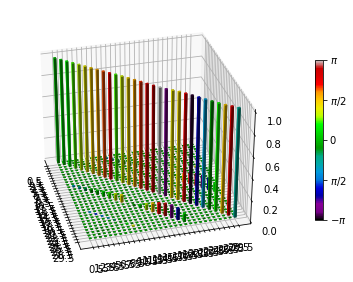

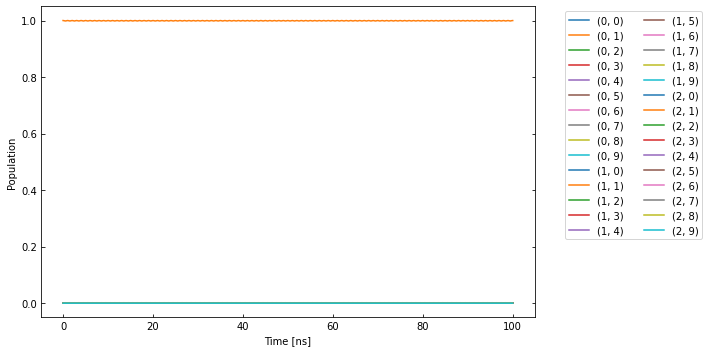

In [8]:
parameter_map = PMap(instructions=gates_arr, model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['swap[0, 1]'])
unitaries = exp.compute_propagators()
plotComplexMatrix(unitaries['swap[0, 1]'].numpy())

psi_init = [[0] * model.tot_dim]
psi_init[0][1] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ['swap[0, 1]']
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)

In [15]:
parameter_map.set_opt_map([
    [("swap[0, 1]", "dQ", "carrier", "freq")],
    [("swap[0, 1]", "dR", "carrier", "freq")]
])

parameter_map.print_parameters()

opt = OptimalControl(
    dir_path="./output/",
    fid_func=fidelities.average_infid_set,
    fid_subspace=["Q", "R"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun": 150},
    run_name="better_swap"
)
exp.set_opt_gates(["swap[0, 1]"])
opt.set_exp(exp)

opt.optimize_controls()
opt.current_best_goal

swap[0, 1]-dQ-carrier-freq            : 1.025 GHz 2pi 
swap[0, 1]-dR-carrier-freq            : 1.025 GHz 2pi 

C3:STATUS:Saving as: /usr/src/app/output/better_swap/2021_12_08_T_11_51_37/open_loop.log


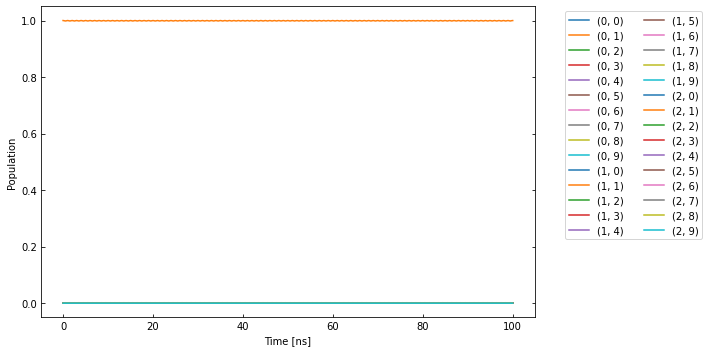

In [13]:
plotPopulation(exp=exp, psi_init=init_state, sequence=sequence, usePlotly=False)